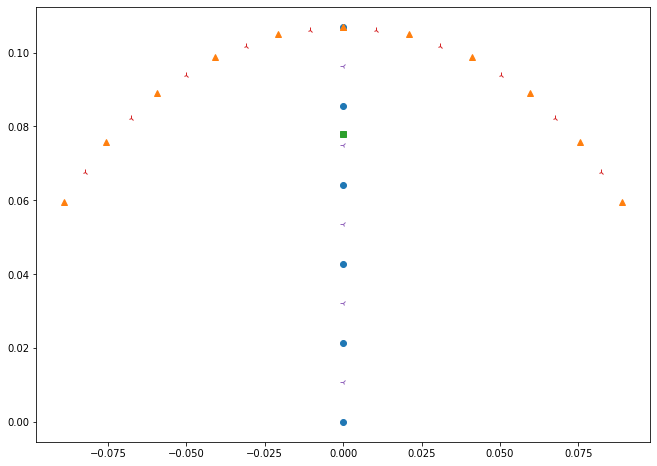

In [1]:
%run center_of_mass_calculation.ipynb

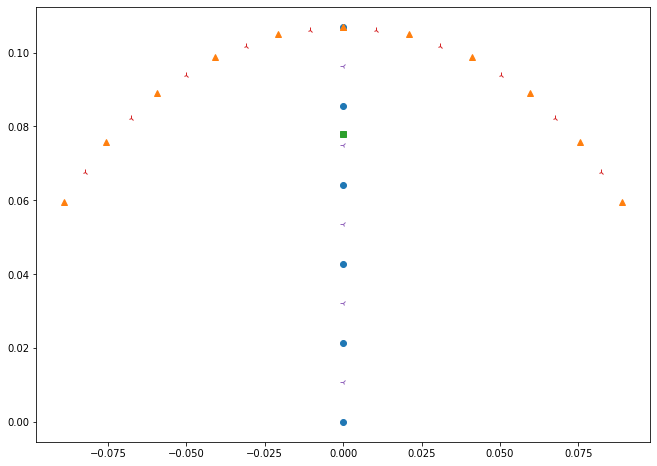

In [2]:
%run 3phase_pm_engine_simulation.ipynb

In [3]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras import backend as K

In [4]:
df = pd.read_csv("full_df.csv", header=None)

In [5]:
data = df.to_numpy()

In [20]:
X = data[:, :28]
y = data[:, 28:] * 100

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=137)

In [22]:
X_train = tf.constant(X_train, dtype="float32")
X_test = tf.constant(X_test, dtype="float32")
y_train = tf.constant(y_train, dtype="float32")
y_test = tf.constant(y_test, dtype="float32")

In [23]:
X_train.shape

TensorShape([113012, 28])

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100_000).batch(256)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1000)

In [25]:
def hundred_relu(x):
    return K.relu(x, max_value=100)

In [26]:
class EvaluatorNetwork(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden_layers = [
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
        ]
        self.output_layer = tf.keras.layers.Dense(1, activation=hundred_relu)
        
    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

In [32]:
evaluator = EvaluatorNetwork()

In [33]:
evaluator.build(input_shape=(None, 28))
evaluator.summary()

Model: "evaluator_network_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  multiple                 112       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             multiple                  1856      
                                                                 
 dense_9 (Dense)             multiple                  4160      
                                                                 
 dense_10 (Dense)            multiple                  4160      
                                                                 
 dense_11 (Dense)            multiple                  65        
                                                                 
Total params: 10,353
Trainable params: 10,297
Non-trainable params: 56
__________________________________________

In [34]:
loss_object = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)

In [35]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [36]:
@tf.function
def evaluator_train_step(params, perf):
    with tf.GradientTape() as tape:
        predictions = evaluator(params, training=True)
        loss = loss_object(perf, predictions)
    gradients = tape.gradient(loss, evaluator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, evaluator.trainable_variables))

    train_loss(loss)


In [37]:
@tf.function
def evaluator_test_step(params, perf):
    predictions = evaluator(params, training=False)
    t_loss = loss_object(perf, predictions)

    test_loss(t_loss)


In [38]:
EPOCHS = 500

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    i = 0
    for params, perf in train_ds:
        evaluator_train_step(params, perf)

    for params, perf in test_ds:
        evaluator_test_step(params, perf)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Test Loss: {test_loss.result()}, '
    )


Epoch 1, Loss: 35.82564926147461, Test Loss: 8.390789031982422, 
Epoch 2, Loss: 5.993653297424316, Test Loss: 5.295508861541748, 
Epoch 3, Loss: 5.120433330535889, Test Loss: 4.961325168609619, 
Epoch 4, Loss: 4.828829288482666, Test Loss: 4.701651573181152, 
Epoch 5, Loss: 4.594082355499268, Test Loss: 4.496532917022705, 
Epoch 6, Loss: 4.398383140563965, Test Loss: 4.316038608551025, 
Epoch 7, Loss: 4.231627464294434, Test Loss: 4.1716203689575195, 
Epoch 8, Loss: 4.0904221534729, Test Loss: 4.03533411026001, 
Epoch 9, Loss: 3.9673683643341064, Test Loss: 3.9146347045898438, 
Epoch 10, Loss: 3.8548216819763184, Test Loss: 3.8111729621887207, 
Epoch 11, Loss: 3.757103204727173, Test Loss: 3.71565318107605, 
Epoch 12, Loss: 3.66855788230896, Test Loss: 3.62931752204895, 
Epoch 13, Loss: 3.584399700164795, Test Loss: 3.5533738136291504, 
Epoch 14, Loss: 3.5103909969329834, Test Loss: 3.4789211750030518, 
Epoch 15, Loss: 3.441911458969116, Test Loss: 3.4145214557647705, 
Epoch 16, Loss: 

KeyboardInterrupt: 

In [39]:
evaluator(tf.reshape(canonical_parameters, shape=(1, 28)))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[50.902786]], dtype=float32)>

In [57]:
trans_mult = tf.constant([45] * 16 + [8] * 12, dtype="float32")
trans_add = tf.constant([5] * 16 + [16] * 12, dtype="float32")

In [58]:
class OptimizerNetwork(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
        ]
        self.output_layer = tf.keras.layers.Dense(28, activation="sigmoid")
        
    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        x *= trans_mult
        x += trans_add
        return x

In [71]:
optimizer = OptimizerNetwork()

In [72]:
optimizer.build(input_shape=(None, 28))
optimizer.summary()

Model: "optimizer_network_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            multiple                  3712      
                                                                 
 dense_33 (Dense)            multiple                  16512     
                                                                 
 dense_34 (Dense)            multiple                  8256      
                                                                 
 dense_35 (Dense)            multiple                  2080      
                                                                 
 dense_36 (Dense)            multiple                  924       
                                                                 
Total params: 31,484
Trainable params: 31,484
Non-trainable params: 0
_________________________________________________________________


In [73]:
loss_object = tf.keras.losses.MeanAbsoluteError()
nadam = tf.keras.optimizers.Nadam(learning_rate=0.0001)

In [74]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [75]:
@tf.function
def optimizer_train_step(params):
    with tf.GradientTape() as tape:
        predictions = optimizer(params, training=True)
        evaluation = evaluator(predictions, training=False) / 100
        loss = 1 - evaluation
    gradients = tape.gradient(loss, optimizer.trainable_variables)
    nadam.apply_gradients(zip(gradients, optimizer.trainable_variables))

    train_loss(loss)
    return predictions

In [76]:
EPOCHS = 200
possible_densities = tf.random.uniform((1, 16), minval=5, maxval=50, dtype="float32", seed=42)
params = tf.random.uniform((1, 12), minval=16, maxval=24, dtype="float32", seed=42)
params = tf.concat([possible_densities, params], axis=1)

params = tf.reshape(params, shape=(1, 28))

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    params = optimizer_train_step(params)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
    )

Epoch 1, Loss: 0.4388824701309204, 
Epoch 2, Loss: 0.4639917016029358, 
Epoch 3, Loss: 0.4491928815841675, 
Epoch 4, Loss: 0.4359947443008423, 
Epoch 5, Loss: 0.4392572045326233, 
Epoch 6, Loss: 0.4349936246871948, 
Epoch 7, Loss: 0.4309144616127014, 
Epoch 8, Loss: 0.425261914730072, 
Epoch 9, Loss: 0.420102596282959, 
Epoch 10, Loss: 0.41752952337265015, 
Epoch 11, Loss: 0.41514408588409424, 
Epoch 12, Loss: 0.41214221715927124, 
Epoch 13, Loss: 0.409623920917511, 
Epoch 14, Loss: 0.40760695934295654, 
Epoch 15, Loss: 0.4058893918991089, 
Epoch 16, Loss: 0.40443551540374756, 
Epoch 17, Loss: 0.40322345495224, 
Epoch 18, Loss: 0.4020686745643616, 
Epoch 19, Loss: 0.40093690156936646, 
Epoch 20, Loss: 0.3997461795806885, 
Epoch 21, Loss: 0.39813679456710815, 
Epoch 22, Loss: 0.39572036266326904, 
Epoch 23, Loss: 0.3930132985115051, 
Epoch 24, Loss: 0.389423131942749, 
Epoch 25, Loss: 0.38727903366088867, 
Epoch 26, Loss: 0.3859454393386841, 
Epoch 27, Loss: 0.3848283290863037, 
Epoch 2

In [77]:
params

<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[50.       , 49.63875  ,  5.0000796,  5.086333 ,  5.0437512,
        50.       ,  5.017602 ,  5.0445957,  5.067348 ,  5.0113072,
        49.676956 ,  5.005883 ,  5.0005207,  5.       , 50.       ,
         5.0142016, 23.998634 , 23.99807  , 16.008509 , 23.998417 ,
        23.976421 , 24.       , 23.99989  , 16.       , 16.       ,
        16.043943 , 23.991905 , 23.999668 ]], dtype=float32)>

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.00400635],
        [0.05779317]], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.1616654>)

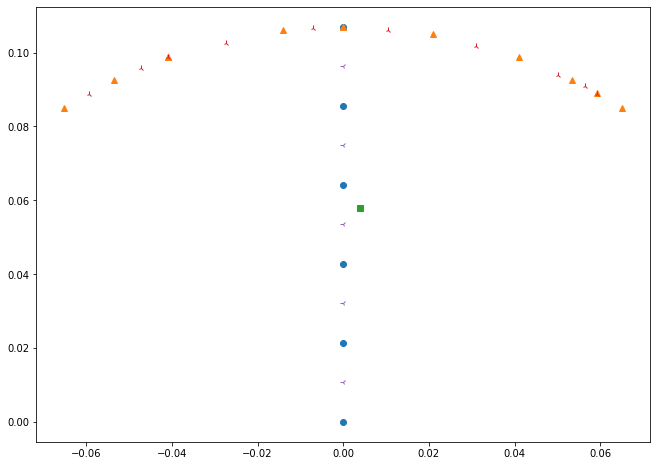

In [78]:
calculate_center_of_mass(tf.reshape(params, (28,)), show_plots=True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.74154335>

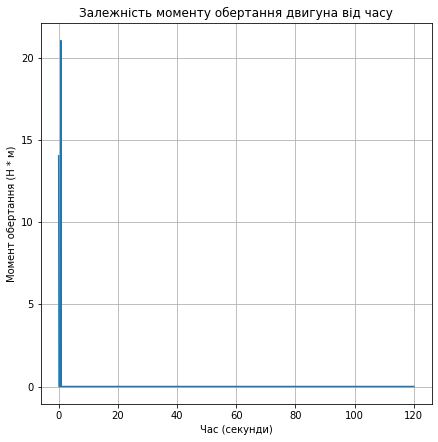

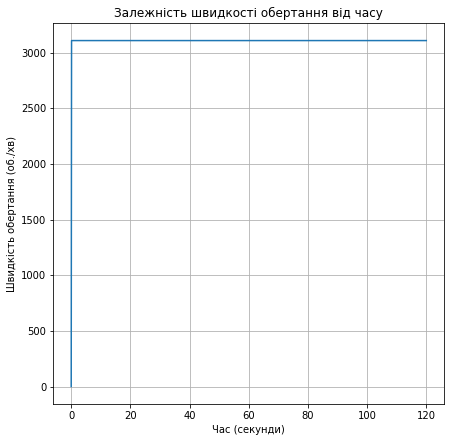

In [79]:
t = np.linspace(0, 120, 1000)
evaluate_efficiency(tf.reshape(params, (28,)), t, show_plots=True)

In [80]:
evaluate_efficiency(tf.reshape(canonical_parameters, (28,)), t)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5056526>

In [82]:
d = tf.concat([tf.reshape(params, (28,)), tf.constant([0.74154335])], axis=0).numpy()
d = tf.reshape(d, shape=(29, 1))
bdf = pd.DataFrame(d)
bdf.to_csv("best_params.csv", index=False, header=False)